In [1]:
%reload_ext autoreload
%autoreload 2

In [18]:
import os
import pandas as pd 
import wandb
import numpy as np
import seaborn as sns
from rich.progress import track
sns.set(context='paper', 
        style='ticks', 
        palette='deep', 
        font='Linux Libertine O', 
        font_scale=2.5, 
        rc={
            'mathtext.fontset': 'stix',
            'lines.linewidth' : 4,
            'lines.markersize' : 12,
        }
)
sns.despine()
os.makedirs('figs', exist_ok=True)

<Figure size 432x288 with 0 Axes>

In [3]:
wandb_user = 'sisaman'
wandb_project = 'GAP'

In [59]:
api = wandb.Api()
runs = api.runs(f"{wandb_user}/{wandb_project}", per_page=2000)

data_list = []
for run in track(runs): 
    data = {}
    data.update(run.summary._json_dict)
    data.update(run.config)
    data['id'] = run.name
    data['name'] = {'GAP-INF': 'GAP-$\infty$', 'SAGE-INF': 'SAGE-$\infty$'}.get(data['name'], data['name'])
    data['epsilon'] = float(data['epsilon'])
    data_list.append(data)

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

# Trade-offs between Privacy and Accuracy

In [55]:
cols = ['id', 'name', 'dp_level', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['GAP-$\infty$', 'SAGE-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']

df = pd.DataFrame(data_list)

df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df.loc[df['name'] == 'GAP-$\infty$', 'dp_level'] = 'none'
df.loc[df['name'] == 'SAGE-$\infty$', 'dp_level'] = 'none'
df = df.loc[(df['dp_level'] != 'edge') | (df['epsilon'].isin([0,5]))]
df = df.loc[(df['dp_level'] != 'node') | (df['epsilon'] == 15)]

idx = df.groupby(['dataset', 'name', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)

def sort_key(row):
    keys = {
        'facebook': 1, 'reddit': 2, 'amazon': 3,     # datasets
        'GAP-$\infty$': 1, 'SAGE-$\infty$': 2, 'GAP-EDP': 3, 'GAP-IP': 4, 'SAGE-EDP': 5, 'MLP': 6, 'GAP-NDP': 7, 'SAGE-NDP': 8, 'MLP-DP': 9,  # methods
        'none': 1, 'edge': 2, 'node': 3,  # levels
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.drop(columns=['id', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci'])
df = df.sort_values(by=['dataset', 'dp_level', 'name'], key=sort_key)
df = df.pivot(columns='dataset', index=['dp_level', 'name', 'epsilon'], values='acc')
df = df.reset_index().sort_values(
    by=['dp_level', 'name'],
    key=sort_key
).set_index(['dp_level', 'name', 'epsilon'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'dp_level': 'privacy level', 'epsilon': 'privacy cost', 'name': 'method'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
df = df.rename({np.inf: '\infty'}, axis=0, level=2)
df = df.rename(lambda x: f'$\epsilon={x}$', axis=0, level=2)
# print(df.to_latex(escape=False))
df

Dataset                                               Facebook  \
Privacy Level Method        Privacy Cost                         
None          GAP-$\infty$  $\epsilon=\infty$  80.2 $\pm$ 0.24   
              SAGE-$\infty$ $\epsilon=\infty$  83.8 $\pm$ 0.35   
Edge          GAP-EDP       $\epsilon=5.0$     76.5 $\pm$ 0.32   
              SAGE-EDP      $\epsilon=5.0$     56.3 $\pm$ 0.91   
              MLP           $\epsilon=0.0$     50.3 $\pm$ 0.39   
Node          GAP-NDP       $\epsilon=15.0$    64.3 $\pm$ 0.41   
              SAGE-NDP      $\epsilon=15.0$    43.9 $\pm$ 0.91   
              MLP-DP        $\epsilon=15.0$    50.2 $\pm$ 0.71   

Dataset                                                 Reddit  \
Privacy Level Method        Privacy Cost                         
None          GAP-$\infty$  $\epsilon=\infty$  99.4 $\pm$ 0.01   
              SAGE-$\infty$ $\epsilon=\infty$  99.1 $\pm$ 0.02   
Edge          GAP-EDP       $\epsilon=5.0$     98.8 $\pm$ 0.03   
              SAGE-EDP      $\epsilon=5.0$     91.2 $\pm$ 0.57   
              MLP           $\epsilon=0.0$     82.7 $\pm$ 0.06   
Node          GAP-NDP       $\epsilon=15.0$    95.1 $\pm$ 0.08   
              SAGE-NDP      $\epsilon=15.0$    74.7 $\pm$ 1.33   
              MLP-DP        $\epsilon=15.0$    81.3 $\pm$ 0.18   

Dataset                                                 Amazon  
Privacy Level Method        Privacy Cost                        
None          GAP-$\infty$  $\epsilon=\infty$  91.2 $\pm$ 0.07  
              SAGE-$\infty$ $\epsilon=\infty$  92.8 $\pm$ 0.11  
Edge          GAP-EDP       $\epsilon=5.0$     84.6 $\pm$ 0.23  
              SAGE-EDP      $\epsilon=5.0$     68.3 $\pm$ 1.05  
              MLP           $\epsilon=0.0$     70.7 $\pm$ 0.30  
Node          GAP-NDP       $\epsilon=15.0$    78.4 $\pm$ 0.12  
              SAGE-NDP      $\epsilon=15.0$    33.8 $\pm$ 1.07  
              MLP-DP        $\epsilon=15.0$    70.8 $\pm$ 0.24

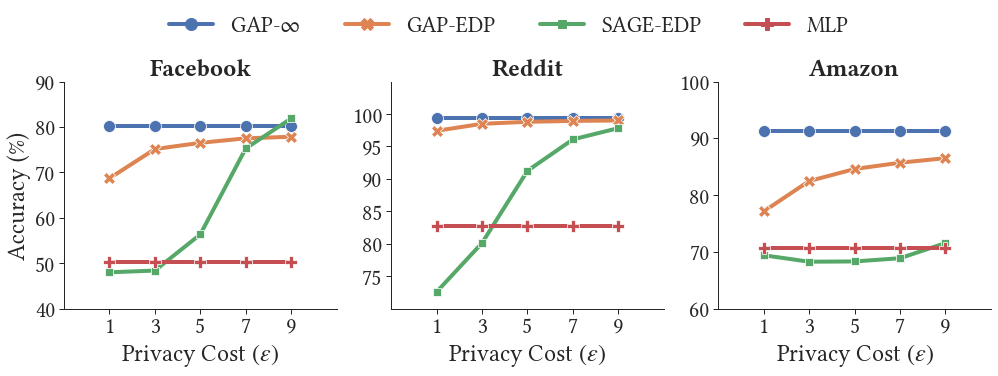

In [58]:
cols = ['id', 'name', 'dp_level', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['GAP-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [1,3,5,7,9]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'name', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
df = df.explode(column='epsilon')
df = df.reset_index(drop=True)

# plot
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='name', col='dataset', aspect=1.2,
                markers=True, dashes=False, style='name',
                hue_order=methods, col_order=datasets, style_order=methods,
                facet_kws={'sharey': False, 'sharex': False})

sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))
g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xlim=(-1,11), xticks=epsilons)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )

g.axes[0][0].set(ylim=(40,90),ylabel='Accuracy (%)')
g.axes[0][1].set(ylim=(70,105),yticks=range(75,105,5))
g.axes[0][2].set_ylim(60,100)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/edge1.pdf')

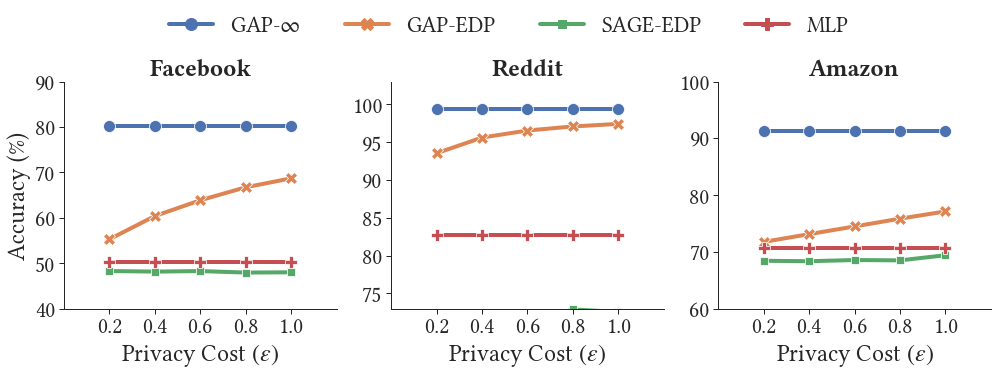

In [39]:
cols = ['id', 'name', 'dp_level', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['GAP-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [0.2, 0.4, 0.6, 0.8, 1]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'name', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
df = df.explode(column='epsilon')
df = df.reset_index(drop=True)

# plot
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='name', col='dataset', aspect=1.2,
                markers=True, dashes=False, style='name',
                hue_order=methods, col_order=datasets, style_order=methods,
                facet_kws={'sharey': False, 'sharex': False})

sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))
g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xlim=(0,1.2), xticks=epsilons)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )

g.axes[0][0].set(ylim=(40,90),ylabel='Accuracy (%)')
g.axes[0][1].set(ylim=(73,103),yticks=range(75,105,5))
g.axes[0][2].set_ylim(60,100)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/edge2.pdf')

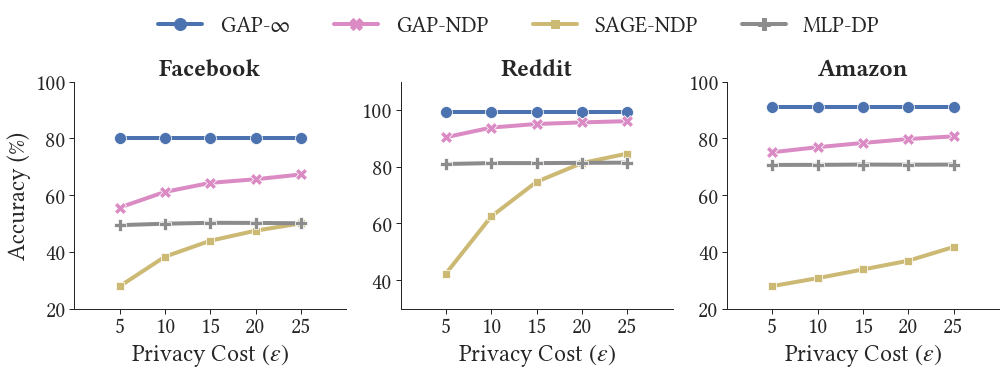

In [43]:
cols = ['id', 'name', 'dp_level', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['GAP-$\infty$', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [5,10,15,20,25]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'name', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
df = df.explode(column='epsilon')
df = df.reset_index(drop=True)

# plot
palette = sns.color_palette()
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='name', col='dataset', aspect=1.2,
                markers=True, dashes=False, style='name',
                hue_order=methods, col_order=datasets, style_order=methods, 
                palette=[palette[0], palette[-4], palette[-2], palette[-3]],
                facet_kws={'sharey': False, 'sharex': False})

sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))
g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xlim=(0,30), xticks=epsilons)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )

g.axes[0][0].set(ylim=(20,100),ylabel='Accuracy (%)')
g.axes[0][1].set(ylim=(30,110),)
g.axes[0][2].set_ylim(20,100)

g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/node1.pdf')

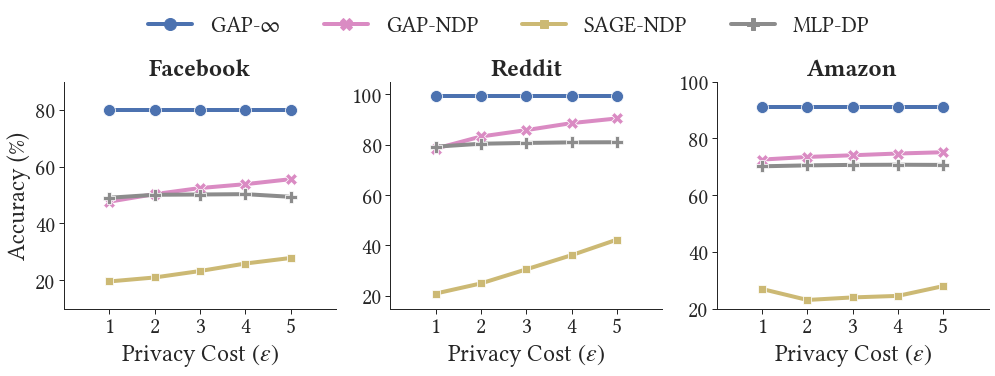

In [44]:
cols = ['id', 'name', 'dp_level', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['GAP-$\infty$', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [1,2,3,4,5]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'name', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
df = df.explode(column='epsilon')
df = df.reset_index(drop=True)

# plot
palette = sns.color_palette()
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='name', col='dataset', aspect=1.2,
                markers=True, dashes=False, style='name',
                hue_order=methods, col_order=datasets, style_order=methods, 
                palette=[palette[0], palette[-4], palette[-2], palette[-3]],
                facet_kws={'sharey': False, 'sharex': False})

sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))
g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xlim=(0,6), xticks=epsilons)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )

g.axes[0][0].set(ylim=(10,90),ylabel='Accuracy (%)')
g.axes[0][1].set(ylim=(15,105),)
g.axes[0][2].set_ylim(20,100)

g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/node2.pdf')

# Effectiveness of the encoder module

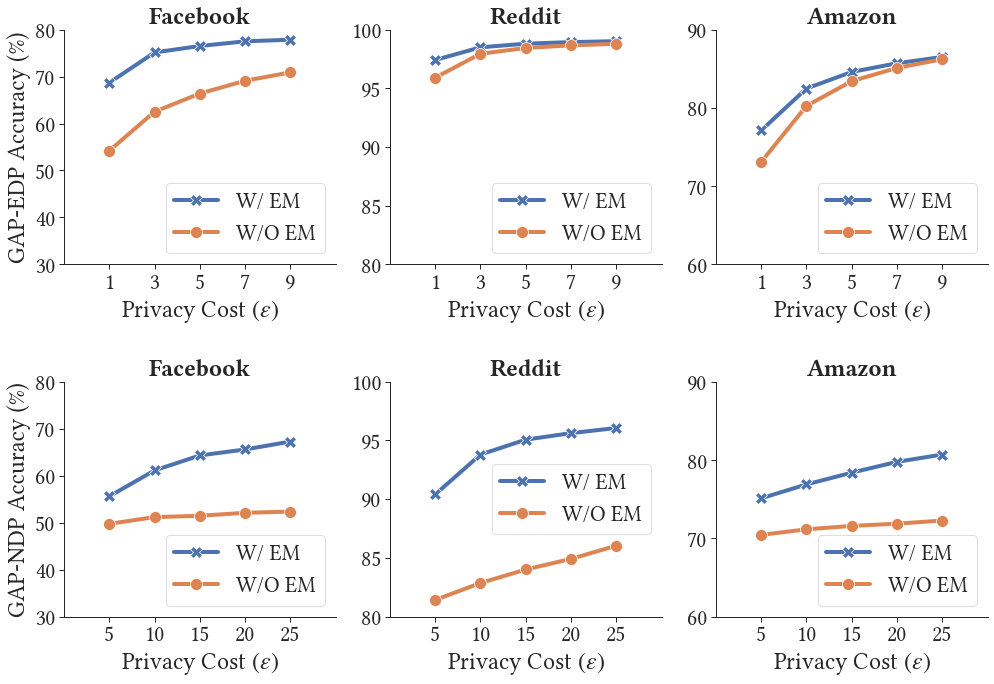

In [8]:
cols = ['id', 'name', 'dp_level', 'hops', 'dataset', 'encoder_layers', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-EDP', 'GAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df = df[df['dataset'].isin(datasets)]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'name', 'epsilon', 'encoder_layers'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['encoder_layers'] = df['encoder_layers'].astype(str)
df = df.reset_index(drop=True)

g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='encoder_layers', col='dataset', row='name', aspect=1.2,
                col_order=datasets, row_order=methods, hue_order=['2', '0'], markers=True, dashes=False, style='encoder_layers', legend=False,
                facet_kws={'sharey': False, 'sharex': False})

g.set(xlabel='Privacy Cost $(\epsilon)$')
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.set_xlim((-1,11) if method=='GAP-EDP' else (0,30))
        ax.set_xticks(range(1,10,2) if method=='GAP-EDP' else range(5,30,5))
        # ax.set_yticks(range(60,95,5) if dataset == 'amazon' else range(30,85,10))
        ax.legend(labels=['W/ EM', 'W/O EM'], loc='right' if dataset == 'reddit' and method == 'GAP-NDP' else 'lower right')
        ax.set_ylabel(f'{method} Accuracy (%)' if dataset == datasets[0] else None)
g.fig.subplots_adjust(hspace=0.5, wspace=0.4)
g.axes[0][0].set_ylim(30,80)
g.axes[0][1].set_ylim(80,100)
g.axes[0][2].set_ylim(60,90)
g.axes[1][0].set_ylim(30,80)
g.axes[1][1].set_ylim(80,100)
g.axes[1][2].set_ylim(60,90)

g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/encoder.pdf')

# Effect of the number of hops

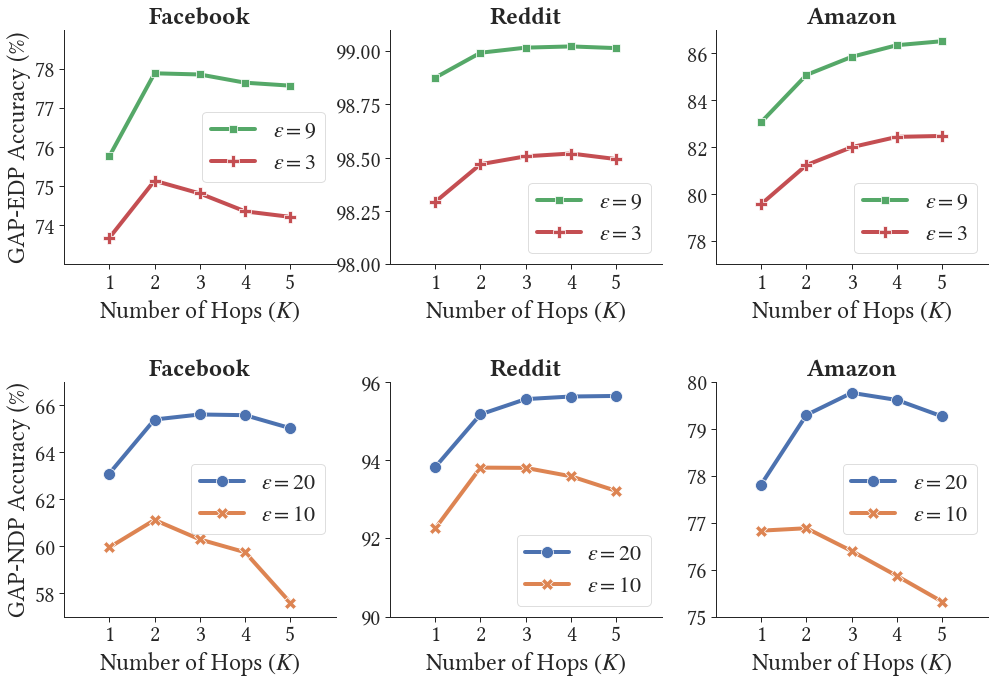

In [9]:
cols = ['name', 'dataset', 'epsilon', 'hops', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-EDP', 'GAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [20,10,9,3]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons)]

# select best models based on valication accuracy
idx = df.groupby(['name', 'dataset', 'epsilon', 'hops'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
epsilons = list(map(str, epsilons))
df['epsilon'] = df['epsilon'].astype(str)

g = sns.relplot(kind='line', data=df, hue='epsilon', y='test/acc_mean', x='hops', col='dataset', row='name', aspect=1.2,
                col_order=datasets, row_order=methods, markers=True, dashes=False, style='epsilon', legend=False,
                facet_kws={'sharey': False, 'sharex': False})

g.set(xlabel='Number of Hops $(K)$', xlim=(0,6), xticks=range(1,6))
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.legend(
            labels=[f'$\epsilon={eps}$' for eps in df.loc[(df['name'] == method) & (df['dataset'] == dataset), 'epsilon'].unique()],
            loc='lower right' if dataset == 'reddit' else None,
        )
        ax.set_ylabel(f'{method} Accuracy (%)' if dataset == datasets[0] else None)
        
g.axes[0][0].set(ylim=(73,79), yticks=range(74,79))
g.axes[0][1].set(ylim=(98,99.1))
g.axes[0][2].set_ylim(77,87)
g.axes[1][0].set_ylim(57,67)
g.axes[1][1].set(ylim=(90,96))
g.axes[1][2].set_ylim(75,80)


g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/hops.pdf')
# df

# Effect of the maximum degree

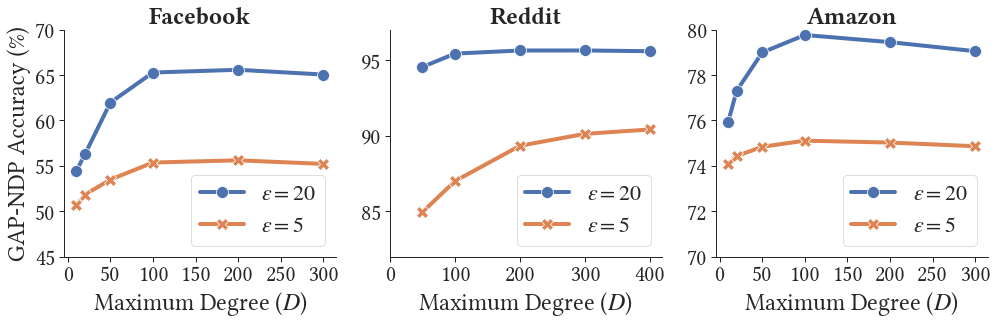

In [10]:
cols = ['name', 'dataset', 'epsilon', 'max_degree', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [20,5]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons)]

# select best models based on valication accuracy
idx = df.groupby(['name', 'dataset', 'epsilon', 'max_degree'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
epsilons = list(map(str, epsilons))
df['epsilon'] = df['epsilon'].astype(str)

g = sns.relplot(kind='line', data=df, x='max_degree', y='test/acc_mean', hue='epsilon',
                col='dataset', aspect=1.2,
                col_order=datasets, 
                hue_order=epsilons, 
                markers=True, dashes=False, style='epsilon', legend=False,
                facet_kws={'sharey': False, 'sharex': False})

g.set(xlabel='Maximum Degree ($D$)', ylabel=None)
for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.set_xticks(range(0,450,100) if dataset == 'reddit' else range(0,350,50) )
    ax.legend(labels=[f"$\epsilon={eps}$" for eps in epsilons], ncol=1, loc='lower right')
        
g.axes[0][0].set(ylim=(45,70), ylabel='GAP-NDP Accuracy (%)')
g.axes[0][1].set_ylim(82,97)
g.axes[0][2].set_ylim(70,80)
# g.axes[1][0].set_ylim(62,70)
# g.axes[1][1].set_ylim(80,80.8)

g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/degree.pdf')

# Computational Cost

In [92]:
cols = ['id', 'name', 'dp_level', 'dataset', 'hops', 'mp_layers', 'val/acc_mean', 'time_mean', 'time_ci',]
methods = ['GAP-$\infty$', 'SAGE-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']

df = pd.DataFrame(data_list)

df = df.filter(items=cols)
df = df[df['name'].isin(methods)]
df.loc[df['name'] == 'GAP-$\infty$', 'dp_level'] = 'none'
df.loc[df['name'] == 'SAGE-$\infty$', 'dp_level'] = 'none'
df = df[(df['hops'] == 3) | (df['mp_layers'] == 3) | (df['name'].str.startswith('MLP'))]
df = df.dropna(subset=['time_mean'])

idx = df.groupby(['dataset', 'name'])['time_mean'].idxmin().values
df = df.loc[idx]

df['time'] = df[['time_mean', 'time_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['time_mean'], row['time_ci']), axis=1
)

def sort_key(row):
    keys = {
        'facebook': 1, 'reddit': 2, 'amazon': 3,     # datasets
        'GAP-$\infty$': 1, 'SAGE-$\infty$': 2, 'GAP-EDP': 3, 'GAP-IP': 4, 'SAGE-EDP': 5, 'MLP': 6, 'GAP-NDP': 7, 'SAGE-NDP': 8, 'MLP-DP': 9,  # methods
        'none': 1, 'edge': 2, 'node': 3,  # levels
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.drop(columns=['id', 'val/acc_mean', 'time_mean', 'time_ci'])
df = df.sort_values(by=['dataset', 'dp_level', 'name'], key=sort_key)
df = df.pivot(columns='dataset', index=['dp_level', 'name'], values='time')
df = df.reset_index().sort_values(
    by=['dp_level', 'name'],
    key=sort_key
).set_index(['dp_level', 'name'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'dp_level': 'privacy level', 'name': 'method'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
# print(df.to_latex(escape=False))
df

Dataset                             Facebook           Reddit  \
Privacy Level Method                                            
None          GAP-$\infty$    2.4 $\pm$ 0.29   4.8 $\pm$ 0.35   
              SAGE-$\infty$   3.5 $\pm$ 0.43  58.6 $\pm$ 0.24   
Edge          GAP-EDP         2.0 $\pm$ 0.32   3.9 $\pm$ 1.34   
              SAGE-EDP        2.1 $\pm$ 0.30  18.8 $\pm$ 0.96   
              MLP             1.0 $\pm$ 0.24   2.3 $\pm$ 0.26   
Node          GAP-NDP        11.3 $\pm$ 1.71  23.9 $\pm$ 2.04   
              MLP-DP          6.7 $\pm$ 3.80   5.1 $\pm$ 2.14   

Dataset                                Amazon  
Privacy Level Method                           
None          GAP-$\infty$    23.0 $\pm$ 0.46  
              SAGE-$\infty$  224.8 $\pm$ 0.69  
Edge          GAP-EDP         15.9 $\pm$ 0.21  
              SAGE-EDP       225.9 $\pm$ 0.71  
              MLP             11.8 $\pm$ 0.25  
Node          GAP-NDP         71.5 $\pm$ 2.16  
              MLP-DP          22.1 $\pm$ 4.20